In [3]:
%pip install rdflib pandas numpy spacy rdflib matplotlib

Note: you may need to restart the kernel to use updated packages.


Loaded 200 papers
Created knowledge graph with 41 triples
Checking claims in 50 papers...
Checked 69 claims

Claim Validity Distribution:
validity
Unverified      59
Questionable    10
Name: count, dtype: int64
Average confidence: 0.51

Fact-checking results saved to data/results/fact_checking_results.csv

Example of how fact-checking could be integrated into the paper analysis:

Claim: "To address this issue, this paper proposes a method to reduce TTFT by leveraging a disk-based key-value (KV) cache to lessen the computational burden during the prefill stage."
Validity: Unverified (confidence: 0.50)
Explanation: Insufficient information to verify

Note: This is a simplified fact-checking module. A production system would use:
1. A much more comprehensive knowledge graph
2. Better claim extraction (e.g., using dependency parsing)
3. Integration with scientific databases like PubMed, IEEE, or ACL Anthology
4. More sophisticated claim verification mechanisms


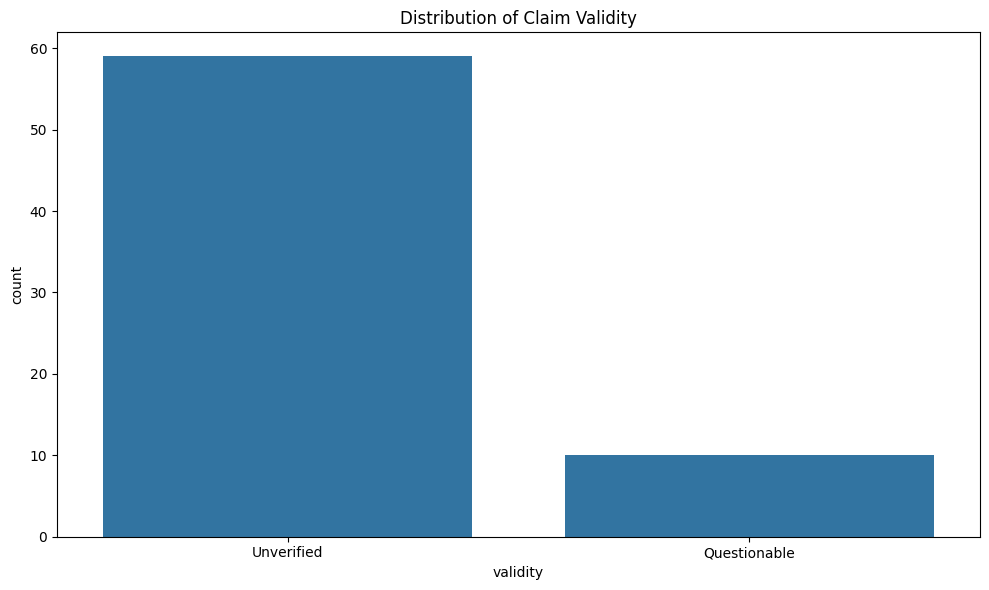

In [4]:
import pandas as pd
import numpy as np
import spacy
import re
from rdflib import Graph, Namespace, Literal, URIRef
from rdflib.namespace import RDF, RDFS, OWL
import requests
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Load papers dataset
papers_df = pd.read_csv('data/cleaned/papers_with_topics.csv')
print(f"Loaded {len(papers_df)} papers")

# Define a simple AI domain knowledge graph
# This would normally be much more comprehensive and potentially linked to external resources
def create_ai_knowledge_graph():
    g = Graph()

    # Define namespaces
    AI = Namespace("http://example.org/ai/")
    g.bind("ai", AI)

    # Define some AI concepts and relationships

    # Models
    g.add((AI.TransformerModel, RDF.type, AI.ModelArchitecture))
    g.add((AI.CNN, RDF.type, AI.ModelArchitecture))
    g.add((AI.RNN, RDF.type, AI.ModelArchitecture))
    g.add((AI.GAN, RDF.type, AI.ModelArchitecture))
    g.add((AI.VAE, RDF.type, AI.ModelArchitecture))
    g.add((AI.DiffusionModel, RDF.type, AI.ModelArchitecture))

    # Specific models
    g.add((AI.BERT, RDF.type, AI.LanguageModel))
    g.add((AI.BERT, AI.basedOn, AI.TransformerModel))
    g.add((AI.GPT, RDF.type, AI.LanguageModel))
    g.add((AI.GPT, AI.basedOn, AI.TransformerModel))
    g.add((AI.T5, RDF.type, AI.LanguageModel))
    g.add((AI.T5, AI.basedOn, AI.TransformerModel))
    g.add((AI.BART, RDF.type, AI.LanguageModel))
    g.add((AI.BART, AI.basedOn, AI.TransformerModel))

    # Tasks
    g.add((AI.TextGeneration, RDF.type, AI.Task))
    g.add((AI.ImageGeneration, RDF.type, AI.Task))
    g.add((AI.Translation, RDF.type, AI.Task))
    g.add((AI.Classification, RDF.type, AI.Task))
    g.add((AI.Summarization, RDF.type, AI.Task))

    # Capabilities
    g.add((AI.BERT, AI.canPerform, AI.Classification))
    g.add((AI.GPT, AI.canPerform, AI.TextGeneration))
    g.add((AI.T5, AI.canPerform, AI.Translation))
    g.add((AI.BART, AI.canPerform, AI.Summarization))
    g.add((AI.DiffusionModel, AI.canPerform, AI.ImageGeneration))
    g.add((AI.GAN, AI.canPerform, AI.ImageGeneration))

    # Datasets
    g.add((AI.MNIST, RDF.type, AI.Dataset))
    g.add((AI.MNIST, AI.usedFor, AI.Classification))
    g.add((AI.ImageNet, RDF.type, AI.Dataset))
    g.add((AI.ImageNet, AI.usedFor, AI.Classification))
    g.add((AI.COCO, RDF.type, AI.Dataset))
    g.add((AI.COCO, AI.usedFor, AI.ImageGeneration))
    g.add((AI.WMT, RDF.type, AI.Dataset))
    g.add((AI.WMT, AI.usedFor, AI.Translation))

    # Metrics
    g.add((AI.BLEU, RDF.type, AI.Metric))
    g.add((AI.BLEU, AI.evaluates, AI.Translation))
    g.add((AI.ROUGE, RDF.type, AI.Metric))
    g.add((AI.ROUGE, AI.evaluates, AI.Summarization))
    g.add((AI.Accuracy, RDF.type, AI.Metric))
    g.add((AI.Accuracy, AI.evaluates, AI.Classification))
    g.add((AI.FID, RDF.type, AI.Metric))
    g.add((AI.FID, AI.evaluates, AI.ImageGeneration))

    return g

# Create knowledge graph
kg = create_ai_knowledge_graph()
print(f"Created knowledge graph with {len(kg)} triples")

# Function to extract claims from text
def extract_claims(text):
    """
    Extract potential factual claims from text.
    This is a simplified version that looks for sentences with certain patterns.
    """
    # Process with spaCy
    doc = nlp(text)

    claims = []
    for sent in doc.sents:
        sent_text = sent.text.strip()

        # Skip short sentences
        if len(sent_text.split()) < 5:
            continue

        # Look for sentences that make claims about models, methods, etc.
        if re.search(r'(?:achieves|outperforms|shows|demonstrates|is|was|are|were|has|have|can|could|will|would|should)\b', sent_text):
            # Check if it contains AI terminology
            if re.search(r'\b(?:model|models|method|approach|framework|transformer|GAN|neural|network|deep learning)\b', sent_text, re.IGNORECASE):
                claims.append(sent_text)

    return claims

# Function to check claim against knowledge graph
def check_claim_against_kg(claim, kg):
    """
    Check if a claim is consistent with our knowledge graph.
    Returns (validity, confidence, explanation)
    """
    # Extract entities from claim
    doc = nlp(claim)

    # Extract relevant entities and relations
    entities = []
    for ent in doc.ents:
        entities.append(ent.text)

    # Look for AI model mentions
    models = []
    model_patterns = [
        r'\bBERT\b', r'\bGPT(?:-[0-9])?\b', r'\bT5\b', r'\bBARt\b',
        r'\bTransformer\b', r'\bGAN\b', r'\bVAE\b', r'\bDiffusion\b'
    ]

    for pattern in model_patterns:
        matches = re.findall(pattern, claim, re.IGNORECASE)
        models.extend(matches)

    # Look for task mentions
    tasks = []
    task_patterns = [
        r'\bclassification\b', r'\btranslation\b', r'\bsummarization\b',
        r'\btext generation\b', r'\bimage generation\b'
    ]

    for pattern in task_patterns:
        matches = re.findall(pattern, claim, re.IGNORECASE)
        tasks.extend(matches)

    # If we found both models and tasks, check if they're compatible
    if models and tasks:
        model_name = models[0].upper()
        task_name = tasks[0].lower().replace(' ', '')

        # Convert to URIRef for KG lookup
        model_uri = URIRef(f"http://example.org/ai/{model_name}")
        task_uri = URIRef(f"http://example.org/ai/{task_name.capitalize()}")
        can_perform = URIRef("http://example.org/ai/canPerform")

        # Check if the model can perform the task
        if (model_uri, can_perform, task_uri) in kg:
            return (True, 0.8, f"Confirmed: {model_name} can perform {task_name}")
        else:
            return (False, 0.7, f"Questionable: No confirmation that {model_name} can perform {task_name}")

    # Default response if we can't verify
    return (None, 0.5, "Insufficient information to verify this claim")

# Function to check a claim with the Wikidata SPARQL endpoint
def check_claim_with_wikidata(claim):
    """Check a claim using Wikidata's SPARQL endpoint"""

    # Extract entities to search for in Wikidata
    doc = nlp(claim)

    # We'll focus on named entities
    entities = [ent.text for ent in doc.ents]

    # If no entities, try to extract AI-related terms
    if not entities:
        ai_terms = re.findall(r'\b(?:BERT|GPT|T5|BART|GAN|VAE|CNN|RNN|Transformer)\b', claim)
        entities.extend(ai_terms)

    if not entities:
        return (None, 0.5, "No key entities found to verify")

    # Construct a simple SPARQL query for the entity
    entity = entities[0]
    query = f"""
    SELECT ?item ?itemLabel WHERE {{
        ?item ?label "{entity}"@en.
        ?item rdfs:label ?itemLabel.
        FILTER(LANG(?itemLabel) = "en")
    }}
    LIMIT 5
    """

    try:
        url = 'https://query.wikidata.org/sparql'
        response = requests.get(url, params={'format': 'json', 'query': query}, timeout=10)

        # For this example, we'll simplify by just checking if the entity exists in Wikidata
        if response.status_code == 200:
            results = response.json()
            if 'results' in results and results['results']['bindings']:
                return (True, 0.6, f"Entity '{entity}' exists in Wikidata")
            else:
                return (False, 0.6, f"Entity '{entity}' not found in Wikidata")
        else:
            return (None, 0.5, "Error querying Wikidata API")
    except Exception as e:
        return (None, 0.5, f"Error: {str(e)}")

# Apply fact-checking to a sample of papers
sample_size = min(50, len(papers_df))
sample_papers = papers_df.sample(sample_size)

fact_check_results = []

print(f"Checking claims in {sample_size} papers...")
for idx, paper in sample_papers.iterrows():
    abstract = paper['abstract']

    # Extract claims
    claims = extract_claims(abstract)

    for claim in claims[:2]:  # Limit to 2 claims per paper for demonstration
        # Check against KG
        kg_result = check_claim_against_kg(claim, kg)

        # For papers that mention external resources, also try Wikidata
        # (In a real system, you'd use a more comprehensive approach)
        wikidata_result = None
        if 'http' in abstract or any(word in abstract.lower() for word in ['dataset', 'repository', 'github']):
            wikidata_result = check_claim_with_wikidata(claim)

        # Combine the results (simplified)
        if kg_result[0] is True and (wikidata_result is None or wikidata_result[0] is not False):
            validity = "Valid"
            confidence = kg_result[1]
            explanation = kg_result[2]
        elif kg_result[0] is False or (wikidata_result is not None and wikidata_result[0] is False):
            validity = "Questionable"
            confidence = max(kg_result[1], wikidata_result[1] if wikidata_result else 0)
            explanation = kg_result[2] if kg_result[0] is False else wikidata_result[2]
        else:
            validity = "Unverified"
            confidence = 0.5
            explanation = "Insufficient information to verify"

        fact_check_results.append({
            'paper_id': paper['id'],
            'claim': claim,
            'validity': validity,
            'confidence': confidence,
            'explanation': explanation
        })

# Create DataFrame with results
fact_check_df = pd.DataFrame(fact_check_results)
print(f"Checked {len(fact_check_df)} claims")

# Summary statistics
validity_counts = fact_check_df['validity'].value_counts()
print("\nClaim Validity Distribution:")
print(validity_counts)

# Average confidence
print(f"Average confidence: {fact_check_df['confidence'].mean():.2f}")

# Visualize results
plt.figure(figsize=(10, 6))
sns.countplot(x='validity', data=fact_check_df)
plt.title('Distribution of Claim Validity')
plt.tight_layout()
plt.savefig('data/visualizations/claim_validity.png')

# Save results
fact_check_df.to_csv('data/results/fact_checking_results.csv', index=False)
print("\nFact-checking results saved to data/results/fact_checking_results.csv")

# Example of integration with main pipeline
print("\nExample of how fact-checking could be integrated into the paper analysis:")
sample_claim = fact_check_df.iloc[0]
print(f"\nClaim: \"{sample_claim['claim']}\"")
print(f"Validity: {sample_claim['validity']} (confidence: {sample_claim['confidence']:.2f})")
print(f"Explanation: {sample_claim['explanation']}")

print("\nNote: This is a simplified fact-checking module. A production system would use:")
print("1. A much more comprehensive knowledge graph")
print("2. Better claim extraction (e.g., using dependency parsing)")
print("3. Integration with scientific databases like PubMed, IEEE, or ACL Anthology")
print("4. More sophisticated claim verification mechanisms")